<a href="https://colab.research.google.com/github/rcelebi/iswc2020-smarttask/blob/master/Word2Vec_DBPedia_ontology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random

In [ ]:
dbpedia_types = pd.read_csv('https://raw.githubusercontent.com/smart-task/smart-dataset/master/evaluation/dbpedia/dbpedia_types.tsv', sep='\t')

In [ ]:
dbpedia_types.head()

,Type,Depth,Parent
0,dbo:BasketballLeague,4,dbo:SportsLeague
1,dbo:NaturalEvent,2,dbo:Event
2,dbo:Province,6,dbo:GovernmentalAdministrativeRegion
3,dbo:LunarCrater,4,dbo:Crater
4,dbo:MotorsportSeason,2,dbo:SportsSeason


In [ ]:
dbpedia_df = pd.read_json('https://raw.githubusercontent.com/smart-task/smart-dataset/master/datasets/DBpedia/smarttask_dbpedia_train.json')

In [ ]:
dbpedia_df.head()

,id,question,category,type
0,dbpedia_1177,Was Jacqueline Kennedy Onassis a follower of M...,boolean,[boolean]
1,dbpedia_14427,What is the name of the opera based on Twelfth...,resource,"[dbo:Opera, dbo:MusicalWork, dbo:Work]"
2,dbpedia_16615,When did Lena Horne receive the Grammy Award f...,literal,[date]
3,dbpedia_23480,Do Prince Harry and Prince William have the sa...,boolean,[boolean]
4,dbpedia_3681,What is the subsidiary company working for Leo...,resource,"[dbo:EducationalInstitution, dbo:Organisation,..."


In [ ]:
# import DBPedia class hierarchy
def import_db_hry(concepts_df):
    grouped= concepts_df.groupby('Parent')
    sequence = []
    for name, group in grouped:
        path = group['Type'].tolist()
        #print (name, path)
        sequence.append(path + [name])
        if len(path) > 3:
          for i in range(100):
            s = random.sample(path,3)
            sequence.append(s)
            #print (s)
    return sequence

In [ ]:
sequence = import_db_hry(dbpedia_types)

In [ ]:
sequence[:10]

[['dbo:Sales', 'dbo:Sport', 'dbo:Game', 'dbo:Activity'],
 ['dbo:AdultActor', 'dbo:VoiceActor', 'dbo:Actor'],
 ['dbo:ClericalAdministrativeRegion',
  'dbo:GovernmentalAdministrativeRegion',
  'dbo:HistoricalAreaOfAuthority',
  'dbo:AdministrativeRegion'],
 ['dbo:Family',
  'dbo:Employer',
  'dbo:Person',
  'dbo:Organisation',
  'dbo:Deity',
  'dbo:Agent'],
 ['dbo:Employer', 'dbo:Organisation', 'dbo:Deity'],
 ['dbo:Organisation', 'dbo:Family', 'dbo:Employer'],
 ['dbo:Person', 'dbo:Family', 'dbo:Employer'],
 ['dbo:Employer', 'dbo:Organisation', 'dbo:Person'],
 ['dbo:Deity', 'dbo:Family', 'dbo:Person'],
 ['dbo:Deity', 'dbo:Family', 'dbo:Organisation']]

In [ ]:
type_list= dbpedia_df[dbpedia_df['category']=='resource'].type

In [ ]:
cluster_dict ={}
for ts in type_list.values:
  if len(ts) > 0:
    top_level = ts[-1]
    for i in range(len(ts)):
        cluster_dict[ts[i]]= top_level

In [ ]:
for s in type_list.tolist():
    sequence.append(s)

In [ ]:
import gensim

In [ ]:
# train Word2Vec model for DBPedia class hierarchy
model= gensim.models.Word2Vec(size=100,min_count=0, window=5, sg=1, iter=5,cbow_mean=1)
model.build_vocab(sequence)

In [ ]:
model.train(sequence, total_examples=model.corpus_count, epochs=5)

(138979, 224800)

In [ ]:
model.wv.most_similar('dbo:Event',topn=5)

[('dbo:LifeCycleEvent', 0.9876939654350281),
 ('dbo:SportsEvent', 0.9873857498168945),
 ('dbo:NaturalEvent', 0.9868661761283875),
 ('dbo:Competition', 0.9864869117736816),
 ('dbo:SocietalEvent', 0.9815332889556885)]

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.patches as mpatches
%matplotlib inline

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def tsne_plot(model, clusters_dict):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #set up colors per clusters using a dict
    #number_of_colors = 44

    #color = {v:"#"+''.join([random.choice('13579ACEF') for j in range(6)])
    #         for v in set(clusters_dict.values())}
    data=set(clusters_dict.values())
    cmap = get_cmap(len(data))
    color = {v: cmap(i) for i,v in enumerate(data)}
    #cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
    clusters =[]
    for word in model.wv.vocab:
        if word in clusters_dict:
          tokens.append(model[word])
          labels.append(word)
          clusters.append(clusters_dict[word])
    
    #tsne_model = TSNE( n_components=3, random_state=23)
    #new_values = tsne_model.fit_transform(tokens)
    #new_values = PCA(n_components=50).fit_transform(tokens)
   
    #dist = 1 - cosine_similarity(tokens)

    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    mds = MDS(n_components=2,metric=True, max_iter=5000, random_state=1)

    new_values = mds.fit_transform(tokens)  # shape (n_components, n_samples)

    x, y = new_values[:, 0], new_values[:, 1]

        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color=color[clusters[i]],)
        plt.annotate(labels[i], xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.gca().legend(handles=[mpatches.Patch(color=c, label=v) for  v,c in color.items()] ) 
    #plt.gca().legend()
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


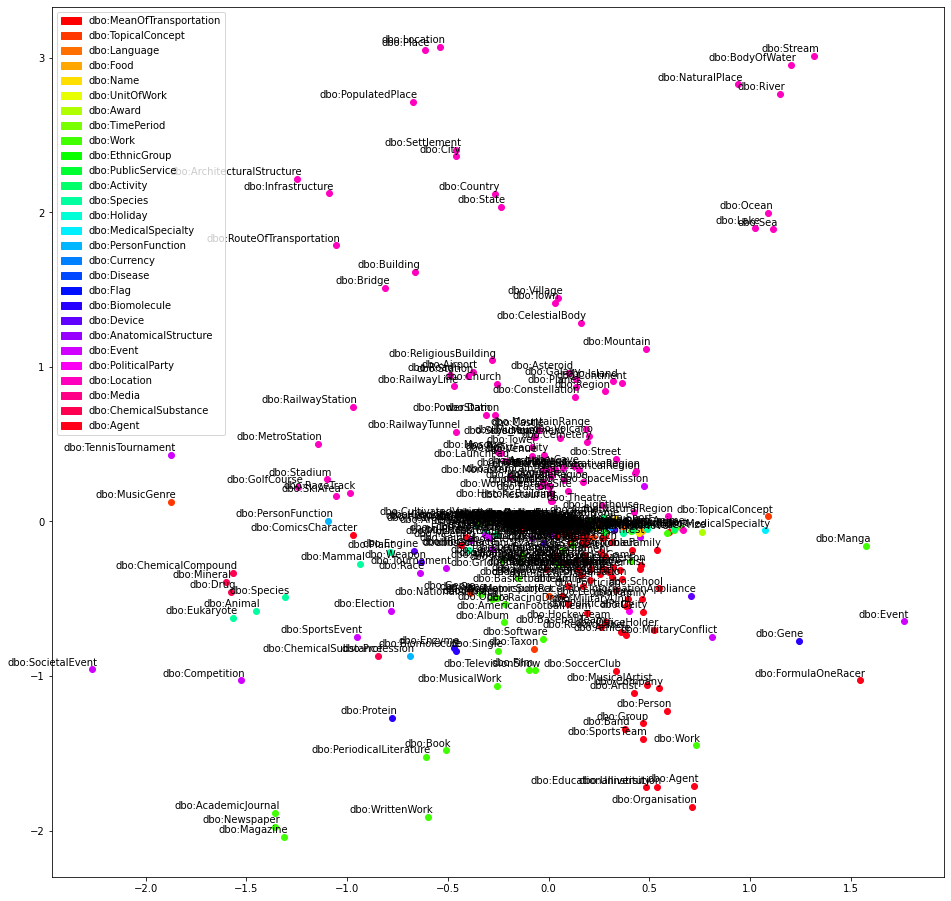

In [ ]:
tsne_plot(model, cluster_dict)